In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 6
fig_height = 4
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/Users/hirofumi48/162348.github.io/posts/2024/Process"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/vnCY0/src/ProgressMeter.jl:626
Sampling 100%|███████████████████████████████| Time: 0:00:01
  iterations:                                   2000
  ratio_divergent_transitions:                  0.0
  ratio_divergent_transitions_during_adaption:  0.0
  n_steps:                                      1
  is_accept:                                    true
  acceptance_rate:                              0.8958173987182666
  log_density:                                  -1.7846089580345201
  hamiltonian_energy:                           1.8056464629957396
  hamiltonian_energy_error:                     0.11001868284981131
  max_hamilto

┌ Info: Finished 2000 sampling steps for 1 chains in 1.256552459 (s)
│   h = Hamiltonian(metric=DiagEuclideanMetric([8.430414950497086]), kinetic=GaussianKinetic())
│   κ = HMCKernel{AdvancedHMC.FullMomentumRefreshment, Trajectory{MultinomialTS, Leapfrog{Float64}, GeneralisedNoUTurn{Float64}}}(AdvancedHMC.FullMomentumRefreshment(), Trajectory{MultinomialTS}(integrator=Leapfrog(ϵ=0.425), tc=GeneralisedNoUTurn{Float64}(10, 1000.0)))
│   EBFMI_est = 0.5481236981823802
└   average_acceptance_rate = 0.8240978202324759


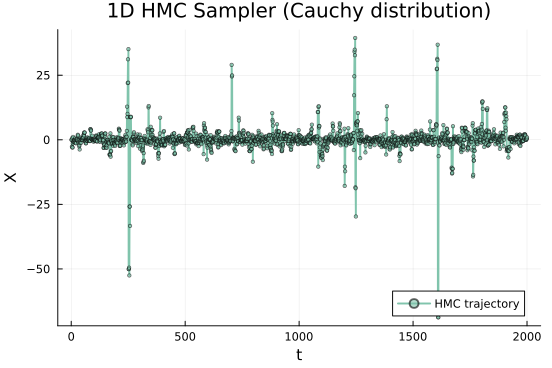

In [2]:
using AdvancedHMC, ForwardDiff
using LogDensityProblems
using LinearAlgebra

# Define the target distribution (1D Cauchy) using the `LogDensityProblem` interface
struct LogTargetDensityCauchy
    loc::Float64
    scale::Float64
end

LogDensityProblems.logdensity(p::LogTargetDensityCauchy, θ) = -log(π) - log(p.scale) - log(1 + ((θ[1] - p.loc)/p.scale)^2)
LogDensityProblems.dimension(p::LogTargetDensityCauchy) = 1
LogDensityProblems.capabilities(::Type{LogTargetDensityCauchy}) = LogDensityProblems.LogDensityOrder{0}()

# Choose initial parameter value for 1D
initial_θ = [randn()]

# Define the Cauchy distribution with location and scale
loc, scale = 0.0, 1.0
ℓπ = LogTargetDensityCauchy(loc, scale)

# Set the number of samples to draw and warmup iterations
n_samples, n_adapts = 2_000, 1_000

# Define a Hamiltonian system
metric = DiagEuclideanMetric(1)
hamiltonian = Hamiltonian(metric, ℓπ, ForwardDiff)

# Define a leapfrog solver, with the initial step size chosen heuristically
initial_ϵ = find_good_stepsize(hamiltonian, initial_θ)
integrator = Leapfrog(initial_ϵ)

# Define an HMC sampler with the following components
#   - multinomial sampling scheme,
#   - generalised No-U-Turn criteria, and
#   - windowed adaption for step-size and diagonal mass matrix
kernel = HMCKernel(Trajectory{MultinomialTS}(integrator, GeneralisedNoUTurn()))
adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.8, integrator))

# Run the sampler to draw samples from the specified Cauchy distribution, where
#   - `samples` will store the samples
#   - `stats` will store diagnostic statistics for each sample
samples, stats = sample(hamiltonian, kernel, initial_θ, n_samples, adaptor, n_adapts; progress=true)

# Print the results
using Plots

sample_values = [s[1] for s in samples]

p = plot(1:length(samples), sample_values,
             label="HMC trajectory",
             title="1D HMC Sampler (Cauchy distribution)",
             xlabel="t",
             ylabel="X",
             linewidth=2,
             marker=:circle,
             markersize=2,
             markeralpha=0.6,
             color="#80c4ac")

In [3]:
#| eval: false
# Import the package.
using AdvancedMH
using Distributions
using MCMCChains
using ForwardDiff
using StructArrays
using Random
using LinearAlgebra

# Generate a set of data from the posterior we want to estimate.
data = rand(Normal(0, 1), 30)

# Define the components of a basic model.
insupport(θ) = θ[2] >= 0
dist(θ) = Normal(θ[1], θ[2])
density(θ) = insupport(θ) ? sum(logpdf.(dist(θ), data)) : -Inf

# Construct a DensityModel.
model = DensityModel(density)

# Set up the sampler with a multivariate Gaussian proposal.
σ² = 0.01
spl = MALA(x -> MvNormal((σ² / 2) .* x, σ² * I))

# Define the ambiguous method explicitly
function AdvancedMH.propose(rng::Random.AbstractRNG, sampler::MALA, model::DensityModel)
    return AdvancedMH.propose(rng, AdvancedMH.MHSampler(), model)
end

# Sample from the posterior.
chain = sample(model, spl, 100000; initial_params=ones(2), chain_type=StructArray, param_names=["μ", "σ"])

In [4]:
#| eval: false
# Import the package.
using AdvancedMH
using Distributions
using MCMCChains
using ForwardDiff
using StructArrays

using LinearAlgebra

# Generate a set of data from the posterior we want to estimate.
data = rand(Normal(0, 1), 30)

# Define the components of a basic model.
insupport(θ) = θ[2] >= 0
dist(θ) = Normal(θ[1], θ[2])
density(θ) = insupport(θ) ? sum(logpdf.(dist(θ), data)) : -Inf

# Construct a DensityModel.
model = DensityModel(density)

# Set up the sampler with a multivariate Gaussian proposal.
σ² = 0.01
spl = MALA(x -> MvNormal((σ² / 2) .* x, σ² * I))

# Sample from the posterior.
chain = sample(model, spl, 100000; initial_params=ones(2), chain_type=StructArray, param_names=["μ", "σ"])